# Проект: Маркетинг.

## Описание проекта.

Интернет-магазин собирает историю покупателей, проводит рассылки предложений и планирует будущие продажи.<br/>
Для оптимизации процессов надо выделить пользователей, которые готовы совершить покупку в ближайшее время.

### Описание данных.

**apparel-purchases история покупок**<br/><br/>
Данные о покупках клиентов по дням и по товарам. В каждой записи покупка определенного товара, его цена, количество штук.<br/>
В таблице есть списки идентификаторов, к каким категориям относится товар. Часто это вложенные категории (например автотовары-аксессуары-освежители), но также может включать в начале списка маркер распродажи или маркер женщинам/мужчинам.<br/>
Нумерация категорий сквозная для всех уровней, то есть 44 на второй позиции списка или на третьей – это одна и та же категория. Иногда дерево категорий обновляется, поэтому могут меняться вложенности, например ['4', '28', '44', '1594'] или ['4', '44', '1594']. Как обработать такие случаи – можно предлагать свои варианты решения.<br/>
- client_id идентификатор пользователя/клиента
- quantity количество товаров в заказе
- price цена товара
- category_ids вложенные категории, к которым отнсится товар (идентификаторы категорий)
- date дата покупки
- message_id идентификатор сообщения из рассылки<br/><br/>

**apparel-messages история рекламных рассылок**<br/><br/>
Рассылки, которые были отправлены клиентам из таблицы покупок.<br/>
- bulk_campaign_id идентификатор рекламной кампании (рассылки)
- client_id идентификатор пользователя/клиента
- message_id идентификатор сообщений
- event тип действия, действие с сообщением (отправлено, открыто, покупка...)
- channel канал рассылки
- date дата рассылки
- created_at точное время создания сообщения<br/><br/>

**target**<br/>
- client_id идентификатор клиента
- target клиент совершил покупку в целевом периоде<br/><br/>

**full_campaign_daily_event агрегация общей базы рассылок по дням и типам событий**<br/><br/>
Общая база рассылок огромна, поэтому собрана агрегированная по дням статистика по рассылкам.<br/>
Если будем создавать на основе этой статистики дополнительные признаки, необходимо обратить внимание, что нельзя суммировать по колонкам nunique, потому что это уникальные клиенты в пределах дня, у нас нет данных, повторяются ли они в другие дни.<br/>
- date дата
- bulk_campaign_id идентификатор рассылки
- count_event* общее количество каждого события event
- nunique_event* количество уникальных client_id в каждом событии<br/>
###### * в именах колонок найдете все типы событий event<br/><br/>

**full_campaign_daily_event_channel агрегация по дням с учетом событий и каналов рассылки**<br/>
- date дата
- bulk_campaign_id идентификатор рассылки
- count_event*_channel* общее количество каждого события по каналам
- nunique_event*_channel* количество уникальных client_id по событиям и каналам<br/>
###### * в именах колонок есть все типы событий event и каналов рассылки channel

### Предварительный план.

- Изучить данные
- Разработать полезные признаки
- Создать модель для классификации пользователей    
- Улучшить модель и максимизировать метрику roc_auc
- Выполнить тестирование

**Базовая цель проекта.**

Предсказать вероятность покупки в течение 90 дней.

## Загрузка данных.

### Загрузка библиотек.

In [1347]:
try:
    # Установка всех зависимостей из requirements.txt
    %pip install -r requirements.txt -q
except Exception as error:
    print(f'Ошибка загрузки: {error}')

Note: you may need to restart the kernel to use updated packages.


In [1348]:
try:
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    import re
    import seaborn as sns
    import shap
    import warnings
    from catboost import CatBoostClassifier
    from datetime import timedelta
    from joblib import dump
    from scipy import stats as st
    from phik import phik_matrix
    from phik.report import plot_correlation_matrix
    from sklearn.compose import ColumnTransformer
    from sklearn.dummy import DummyClassifier, DummyRegressor
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.impute import SimpleImputer
    from sklearn.linear_model import LinearRegression, LogisticRegression
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
    from sklearn.svm import SVC
    from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
    from sklearn.metrics import (
        accuracy_score,
        confusion_matrix,
        roc_auc_score,
        recall_score,
        precision_score,
        f1_score)
    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import (
        OneHotEncoder,
        OrdinalEncoder,
        LabelEncoder,
        MinMaxScaler,
        StandardScaler)
except ImportError as error:
    print(f'Ошибка импорта: {error}')

### Константы.

In [1349]:
ZERO = 0
ONE = 1
TWO = 2
THREE = 3
SIX = 6
TEN = 10
ID = 'client_id'
RANDOM_STATE = 42
TEST_SIZE = 0.25
COLOR_ONE = 'SteelBlue'
COLOR_TWO = 'Yellow'
COLOR_THREE = 'Green'
COLOR_FOUR = 'Blues'
PATH = 'datasets/'

### Загрузка данных из csv-файлов в датафрейм.

In [1350]:
try:
    messages = pd.read_csv(f'{PATH}apparel-messages.csv')
    purchases = pd.read_csv(f'{PATH}apparel-purchases.csv')
    target = pd.read_csv(f'{PATH}apparel-target_binary.csv')
    event = pd.read_csv(f'{PATH}full_campaign_daily_event.csv')    
    event_chanel = pd.read_csv(f'{PATH}full_campaign_daily_event_channel.csv')
except FileNotFoundError:
    print(f'Что то пошло не так: {error}')

### Дополнительные настройки.

In [1351]:
# Отключаем предупреждения.
pd.options.mode.chained_assignment = None

# Задаем два знака после запятой для чисел с плавающей запятой.
pd.options.display.float_format = '{:,.2f}'.format

# Игнорирование предупреждений.
warnings.filterwarnings("ignore")

# Установка опции для отображения максимальной ширины столбца.
pd.set_option('display.max_colwidth', None)

### Вспомогательные методы.

In [1352]:
# Добавим имена датафреймов в список.
df_names = ['messages', 'purchases', 'target', 'event', 'event_chanel']

In [1353]:
# Кастомный метод вывода информации о датафрейме.
def custom_info(value,
                name='',
                dtype_recom=False,
                is_result=True,
                sample=False,
                sample_quantity=TEN,
                head_value=0):
    result = (
        pd.DataFrame(value.count(),
                     columns=['non_null_count']))
    result['dtype'] = (
        pd.DataFrame(value.dtypes, 
                     columns=['dtype']))

    if name:
        print(f'\nСтатистика по столбцам, выборка {name}.')

    if dtype_recom:
        result['dtype_recomended'] = (
            pd.DataFrame(
                value.convert_dtypes()
                .dtypes.to_frame()
                .rename(columns={0: 'dtype_recomended'}), 
                        columns=['dtype_recomended']))

    if is_result:
        display(result)
    print(f'Количество записей: {len(value)}')
    print(f'Количество столбцов: {len(value.columns)}')

    if sample:
        display(value.sample(sample_quantity).T)

    if head_value != 0:
        display(value.head(head_value).T)

In [1354]:
# Проверка пустых значений в датафрейме.
def count_none_values_table(value, name=''):
    try:
        result = (
            (value.isna().sum())
            .to_frame()
            .rename(columns={0: 'count_none'})
            .query('count_none > 0'))
        if len(result) != 0:
            print(f'Пропущенные значения в датафрейме {name}.'.strip())
            display(result.sort_values(by='count_none', ascending=True))
        else:
            print(f'В датафрейме {name} нет пропущенных значений.'
                  .replace('  ', ' '))
    except Exception as error:
        print(f'Что пошло не так: {error}')

### Общая информация о полученных датафреймах.

Посмотрим на статистику по столбцам.<br/>
Выведем на экран по 10 случайных позиций данных из каждого датафрейма. Посмотрим на их состав.

In [1355]:
for name in df_names:
    if name in locals():
        custom_info(locals()[name], name, sample=True)
    else:
        print(f'Датафрейм {name} не найден!')


Статистика по столбцам, выборка messages.


,non_null_count,dtype
bulk_campaign_id,12739798,int64
client_id,12739798,int64
message_id,12739798,object
event,12739798,object
channel,12739798,object
date,12739798,object
created_at,12739798,object


Количество записей: 12739798
Количество столбцов: 7


,12109386,2677547,7124969,8234301,3144367,2083518,9634416,6230341,6020876,9669795
bulk_campaign_id,14553,8072,13690,13907,8746,7353,14183,13500,13436,14182
client_id,1515915625559249821,1515915625554874556,1515915625489584476,1515915625963014763,1515915625468142858,1515915625488231550,1515915625579581575,1515915625557013978,1515915625577224968,1515915625764118229
message_id,1515915625559249821-14553-65b706df69d88,1515915625554874556-8072-637f16a5ed074,1515915625489584476-13690-64e34d36802a0,1515915625963014763-13907-651d622b21ba9,1515915625468142858-8746-639c7fcfb8a39,1515915625488231550-7353-635652c253ee2,1515915625579581575-14183-656040b8c560c,1515915625557013978-13500-64b1550f3a94d,1515915625577224968-13436-64a2c7f1c3587,1515915625764118229-14182-656056a8cf000
event,send,send,send,send,send,send,send,open,send,send
channel,mobile_push,email,email,mobile_push,mobile_push,email,mobile_push,mobile_push,mobile_push,email
date,2024-01-29,2022-11-24,2023-08-21,2023-10-04,2022-12-16,2022-10-24,2023-11-24,2023-07-14,2023-07-03,2023-11-24
created_at,2024-01-29 02:04:45,2022-11-24 07:02:03,2023-08-21 11:53:25,2023-10-04 16:57:43,2022-12-16 14:38:33,2022-10-24 09:00:14,2023-11-24 06:24:07,2023-07-14 14:02:58,2023-07-03 14:09:31,2023-11-24 12:24:56



Статистика по столбцам, выборка purchases.


,non_null_count,dtype
client_id,202208,int64
quantity,202208,int64
price,202208,float64
category_ids,202208,object
date,202208,object
message_id,202208,object


Количество записей: 202208
Количество столбцов: 6


,79252,176893,130988,183214,92147,167104,54488,40419,13390,76257
client_id,1515915625490339064,1515915625560755958,1515915625658926902,1515915625590807493,1515915625590281766,1515915625478921155,1515915625781035865,1515915625502454548,1515915625487326519,1515915625468266104
quantity,1,1,1,1,1,1,1,1,1,1
price,599.00,"4,499.00",23.00,29.00,"1,618.00","1,333.00",210.00,39.00,999.00,"1,499.00"
category_ids,"['4', '28', '249', '616']","['2', '18', '258', '441']","['4', '28', '244', '432']","['4', '1822', '38', '479']","['4', '28', '146', '548']","['4', '31', '329', '506']","['4', '27', '287', '544']","['4', '28', '44', '1594']","['4', '28', '244', '432']","['4', '28', '260', '1568']"
date,2022-12-27,2023-11-10,2023-06-09,2023-12-20,2023-03-17,2023-08-30,2022-11-14,2022-09-17,2022-06-15,2022-12-23
message_id,1515915625490339064-9038-63a9a5737f61c,1515915625560755958-14081-654ccd000f3bd,1515915625863742128-13249-6481b8e54796e,1515915625590807493-14342-6581512056f75,1515915625552859072-11031-6414759f7889d,1515915625478921155-13743-64eef7290fe48,1515915625781035865-5112-62b580f24b32a,1515915625502454548-6374-63241bc82a47f,1515915625487326519-4918-62a97ccf3ae2c,1515915625468266104-8902-63a2cebe785f4



Статистика по столбцам, выборка target.


,non_null_count,dtype
client_id,49849,int64
target,49849,int64


Количество записей: 49849
Количество столбцов: 2


,22862,29681,8279,9603,16413,19376,38737,38177,8920,45657
client_id,1515915625543705689,1515915625567614488,1515915625488471379,1515915625489044161,1515915625491388604,1515915625500767739,1515915625658401321,1515915625645469369,1515915625488718594,1515915625885481122
target,0,0,0,0,0,0,0,0,0,0



Статистика по столбцам, выборка event.


,non_null_count,dtype
date,131072,object
bulk_campaign_id,131072,int64
count_click,131072,int64
count_complain,131072,int64
count_hard_bounce,131072,int64
count_open,131072,int64
count_purchase,131072,int64
count_send,131072,int64
count_soft_bounce,131072,int64
count_subscribe,131072,int64


Количество записей: 131072
Количество столбцов: 24


,82949,106966,18991,41201,70294,2723,89422,126763,48752,122260
date,2023-08-12,2024-02-04,2022-09-02,2022-12-11,2023-04-27,2022-06-06,2023-10-16,2024-04-27,2023-01-11,2024-04-10
bulk_campaign_id,13157,14109,4918,3433,12178,4617,13917,15060,6747,13417
count_click,5,0,4,0,1,49,84,286,0,0
count_complain,0,0,0,0,0,0,0,0,0,0
count_hard_bounce,0,0,0,0,0,0,0,0,0,0
count_open,0,31,182,5,4,1315,1568,297,39,5
count_purchase,0,0,0,0,1,2,0,1,0,0
count_send,0,0,0,0,0,0,0,0,0,0
count_soft_bounce,0,0,0,0,0,0,0,0,0,0
count_subscribe,0,0,0,0,0,2,0,0,0,0



Статистика по столбцам, выборка event_chanel.


,non_null_count,dtype
date,131072,object
bulk_campaign_id,131072,int64
count_click_email,131072,int64
count_click_mobile_push,131072,int64
count_open_email,131072,int64
count_open_mobile_push,131072,int64
count_purchase_email,131072,int64
count_purchase_mobile_push,131072,int64
count_soft_bounce_email,131072,int64
count_subscribe_email,131072,int64


Количество записей: 131072
Количество столбцов: 36


,63853,76541,59173,94693,70555,6420,23429,45779,23669,60788
date,2023-03-23,2023-06-01,2023-02-24,2023-12-03,2023-04-29,2022-06-28,2022-09-23,2022-12-30,2022-09-25,2023-03-05
bulk_campaign_id,4962,4918,4981,13157,5782,4895,6698,2795,2003,7293
count_click_email,0,0,0,3,0,3,0,0,0,0
count_click_mobile_push,0,0,0,0,0,0,102,0,0,0
count_open_email,2,19,10,0,1,17,0,5,17,1
count_open_mobile_push,0,0,0,0,0,0,486,0,0,0
count_purchase_email,0,0,0,0,0,0,0,0,0,0
count_purchase_mobile_push,0,0,0,0,0,0,0,0,0,0
count_soft_bounce_email,0,0,0,0,0,0,0,0,0,0
count_subscribe_email,0,0,0,0,0,0,0,0,0,0


### Проверим наличие пропусков в датафреймах.

In [1356]:
for name in df_names:
    if name in locals():
        count_none_values_table(locals()[name], name)
    else:
        print(f'Датафрейм {name} не найден!')

В датафрейме messages нет пропущенных значений.
В датафрейме purchases нет пропущенных значений.
В датафрейме target нет пропущенных значений.
В датафрейме event нет пропущенных значений.
В датафрейме event_chanel нет пропущенных значений.


### Выводы.

По результату изучения общей информации о каждом датафрейме, наблюдаем следующую картину:
* Наборы данных далее датафреймы с данными об истории покупок, истории рекламных рассылок; таргета; агрегации общей базы рассылок по дням и типам событий; агрегации по дням с учетом событий и каналов рассылки.
* Названия колонок в датафреймах приведены к единому формату, в соответствии со «змеиным_регистром».
* Типы данных в колонках `date` и `created_at` необходимо привести к формату даты. 
* В датафреймах отсутствуют пропущенные значения, количество ненулевых значений соотвествует количеству записей в датафреймах.

##  Предобработка данных.

### Изменение типов данных в колонках с датой и временем.

In [1357]:
# Исключим из списка имен датафреймов 'target'.
df_names.remove('target')

In [1358]:
# Преобразуем формат данных в колонках 'date' и 'created_at' в формат даты и времени.
for name in df_names:
    if name in locals():
        locals()[name]['date'] = (
            pd.to_datetime(locals()[name]['date']))
        if name in 'messages':
            locals()[name]['created_at'] = (
                pd.to_datetime(locals()[name]['created_at']))
    else:
        print(f'Датафрейм {name} не найден!')

In [1359]:
# Проверим изменение типа данных в колонках.
for name in df_names:
    if name in locals():
        custom_info(locals()[name], name)
    else:
        print(f'Датафрейм {name} не найден!')


Статистика по столбцам, выборка messages.


,non_null_count,dtype
bulk_campaign_id,12739798,int64
client_id,12739798,int64
message_id,12739798,object
event,12739798,object
channel,12739798,object
date,12739798,datetime64[ns]
created_at,12739798,datetime64[ns]


Количество записей: 12739798
Количество столбцов: 7

Статистика по столбцам, выборка purchases.


,non_null_count,dtype
client_id,202208,int64
quantity,202208,int64
price,202208,float64
category_ids,202208,object
date,202208,datetime64[ns]
message_id,202208,object


Количество записей: 202208
Количество столбцов: 6

Статистика по столбцам, выборка event.


,non_null_count,dtype
date,131072,datetime64[ns]
bulk_campaign_id,131072,int64
count_click,131072,int64
count_complain,131072,int64
count_hard_bounce,131072,int64
count_open,131072,int64
count_purchase,131072,int64
count_send,131072,int64
count_soft_bounce,131072,int64
count_subscribe,131072,int64


Количество записей: 131072
Количество столбцов: 24

Статистика по столбцам, выборка event_chanel.


,non_null_count,dtype
date,131072,datetime64[ns]
bulk_campaign_id,131072,int64
count_click_email,131072,int64
count_click_mobile_push,131072,int64
count_open_email,131072,int64
count_open_mobile_push,131072,int64
count_purchase_email,131072,int64
count_purchase_mobile_push,131072,int64
count_soft_bounce_email,131072,int64
count_subscribe_email,131072,int64


Количество записей: 131072
Количество столбцов: 36


In [1360]:
# Вернем в список имен датафреймов 'target'.
df_names.append('target')

### Исследование датафреймов на явное дублирование данных.

In [1361]:
# Метод рассчета процента потери данных при удалении дубликатов.
def calculate_loss_percentage(value, duplicates_count):
    total_rows = len(value)
    if total_rows == 0:
        return 0.0
    loss_percentage = (duplicates_count / total_rows) * 100
    return round(loss_percentage, 2)

In [1362]:
# Метод анализа дубликатов в датафреймах.
def analyze_duplicates(value, name):
    print(f'Количество явных дубликатов в датафрейме {name} - ', end='')
    duplicates_count = value.duplicated().sum()
    print(duplicates_count)
    if duplicates_count > 0:
        # Расчет процента потерь
        loss_count = calculate_loss_percentage(value, duplicates_count)
        print(f'Процент потерь при удалении дубликатов:', end='')
        print(f' {loss_count}% (будет удалено {duplicates_count} строк из {len(value)})')
        # Пример первых дублирующихся строк
        print('\nПример дубликатов:')
        print(value[value.duplicated(keep=False)].head(TWO).to_markdown(tablefmt='grid'))
        print('\n')

In [1363]:
# Проведем анализ дубликатов в датафреймах и рассчитаем процент потери данных.
for name in df_names:
    if name in locals():
        analyze_duplicates(locals()[name], name)
    else:
        print(f'Датафрейм {name} не найден!')

Количество явных дубликатов в датафрейме messages - 48610
Процент потерь при удалении дубликатов: 0.38% (будет удалено 48610 строк из 12739798)

Пример дубликатов:
+--------+--------------------+---------------------+----------------------------------------+---------+-------------+---------------------+---------------------+
|        |   bulk_campaign_id |           client_id | message_id                             | event   | channel     | date                | created_at          |
+========+====================+=====================+========================================+=========+=============+=====================+=====================+
| 964231 |               5723 | 1515915625554535987 | 1515915625554535987-5723-62e2af08e00da | click   | mobile_push | 2022-07-28 00:00:00 | 2022-07-28 15:58:56 |
+--------+--------------------+---------------------+----------------------------------------+---------+-------------+---------------------+---------------------+
| 964232 |           

**По итогу исследования датафреймов на явное дублирование данных, наблюбдаем.**
- Для messages (малый процент потерь) - можно безопасно удалять
- Для purchases (большой процент) - что стоит предпринять и какова причина возникновения:
    * появление дубликатов возможно при покупке одинаковых товаров в одно время, вполне штатная ситуация
    * будем применять агрегацию данных вместо удаления
    * после выполнения агрегации повторно проверим на явное дублирование данных

Удалим явные дубликаты в датафрейме `messages`.

In [1364]:
messages = messages.drop_duplicates()

In [1365]:
# Проверим наличие дубликатов в датафрейме 'messages' после обработки.
analyze_duplicates(messages, 'messages')

Количество явных дубликатов в датафрейме messages - 0


### Исследование датафреймов на неявное дублирование данных.

In [1366]:
# Создадим метод для проверки уникальных значений в столбцах.
def check_unique_value(data, name, type='object', cols=[], id=[]):
    # создаём список с категориями
    if not cols:
        cols = data.drop(columns=[ID]).select_dtypes(include=type).columns.tolist()
    if cols:
        print(f'\nУникальные значения поля(ей) в датафрейме {name}:')
        for value in cols:
            print(f'{value:16} - {data[value].unique().tolist()}')   
        print(f'Размер датафрейма - {data.shape}')

In [1367]:
# Проверим уникальные значения в текстовых столбцах датафрейма messages.
check_unique_value(messages, 'messages', cols=['event', 'channel'])


Уникальные значения поля(ей) в датафрейме messages:
event            - ['open', 'click', 'purchase', 'send', 'unsubscribe', 'hbq_spam', 'hard_bounce', 'subscribe', 'soft_bounce', 'complain', 'close']
channel          - ['email', 'mobile_push']
Размер датафрейма - (12691188, 7)


В датафрейме `messages` неявное дублирование данных отсутствует.<br/>

Приведем расшифровку поля event датафрейма messages:
- send - Сообщение отправлено клиенту - Факт доставки сообщения в канал коммуникации;
- open - Клиент открыл сообщение - Индикатор интереса (для email/push);
- click - Клиент перешел по ссылке в сообщении - Высокий уровень вовлеченности;
- purchase - Совершена покупка после взаимодействия с сообщением - Конверсия в продажу;
- soft_bounce - Временная ошибка доставки (например, переполненный почтовый ящик) - Возможность повторной отправки;
- hard_bounce - Постоянная ошибка доставки (несуществующий email/номер) - Рекомендуется исключить из базы;
- subscribe - Подписка на рассылки - Явное согласие на коммуникацию;
- unsubscribe - Отписка от рассылок - Отказ от получения сообщений;
- complain - Жалоба на спам (для email) - Серьезный сигнал для остановки рассылок;
- hbq_spam - Помечено как спам (жесткий bounce + spam) - Наихудший сценарий доставки;
- close - Закрытие push-уведомления без действия- Нулевое взаимодействие.<br/>

Особенности по каналам (поле channel):<br/>

Для email:
- Основные события: send, open, click, purchase, soft_bounce, hard_bounce
- Критические события: complain, hbq_spam (могут повлиять на репутацию отправителя)<br/>

Для mobile_push:
- Основные события: send, open, close, click
- Нет механизма жалоб на спам (в отличие от email)

In [1368]:
# Добавим имена датафреймов в список.
df_names = ['messages', 'purchases', 'target']

In [1369]:
# Проверка наличия дублей в поле уникальный идентификатор, в датафреймах.
for name in df_names:
    if name in locals():
        print(f"Количество дублей в поле id, датафрейм {name} - \
{locals()[name][ID].duplicated().sum()}")
    else:
        print(f'Датафрейм {name} не найден!')

Количество дублей в поле id, датафрейм messages - 12637859
Количество дублей в поле id, датафрейм purchases - 152359
Количество дублей в поле id, датафрейм target - 0


По итогу проверки наличия дублей в поле уникального идентификатора `client_id`, в датафреймах, наблюдаем:<br/>

Датафрейм messages:<br/>
- 12,637,859 дублей client_id (крайне высокий показатель)
- Ожидаемо, так как:<br/>
Каждый клиент получает множественные рассылки.<br/>
Одно сообщение может генерировать несколько событий (send → open → click).<br/>
- Удалять не будем дубликаты, т.к. это валидные записи о взаимодействиях.<br/>
Агрегируем статистику по client_id и расчитаем метрики.

Датафрейм purchases:
- 152,359 дублей client_id (умеренное количество)
- Отражает:<br/>
Многократные покупки клиентов.<br/>
Нормальное поведение для истории транзакций.<br/>
- Сохраним все записи для построения RFM-метрик (подход для прогнозирования покупательского поведения), так же применим агрегацию по client_id.

Датафрейм target:
- 0 дублей (идеально)
- Каждый client_id представлен единожды, что корректно для целевой переменной.<br/>
- Оставим без изменений (уже чистые данные), будем использовать как основу для соединения.<br/>

Итоговый workflow:
- Датафрейм messages (сырые события) → Агрегация по client_id → Признаки.
- Датафрейм purchases (транзакции) → RFM-анализ → Признаки.
- Датафрейм target (клиенты) → Объединяющая основа.<br/>
<pre>                     ↓</pre>
          Финальный датафрейм для модели

## Исследовательский анализ данных

In [1370]:
# Вывод статистики по столбцу датафрейма.
def stats_column(data=target, column='', text='', is_sum=False):
    print(f"\nСтатистика по столбцу '{column}' {text}".strip()+":")
    result = data[column].describe().to_frame()
    if is_sum:
        result = (pd.concat(
            [result, 
             pd.DataFrame({column:[data[column].sum()]}, index=['sum'])]))
    result = result.T
    result['median'] = data[column].agg('median')
    display(result)

In [1371]:
# Кастомный метод для построения гистограммы и диаграммы размаха.
def custom_hist(data=purchases, name='purchases', add_columns=[], del_columns=[ID]):
    ylabel = 'кол-во клиентов'
    columns = data.drop(columns=del_columns).select_dtypes(include=['float64']).columns.to_list()
    columns.extend(add_columns)

    for column in columns:
        stats_column(data=data, column=column, text=f'датафрейм {name}', is_sum=False)
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

        sns.histplot(data[column], kde=True, bins=30, color='skyblue', edgecolor='black', ax=ax[ZERO])
        ax[ZERO].axvline(data[column].mean(), color='red', linestyle='--', label='Среднее')
        ax[ZERO].axvline(data[column].median(), color='green', linestyle=':', label='Медиана')
        ax[ZERO].set_title(f'Распределение признака "{column}"')
        ax[ZERO].set_ylabel(ylabel)
        ax[ZERO].legend()

        sns.boxplot(data[column], ax=ax[ONE])
        ax[ONE].set_title('Диаграмма размаха', fontsize=15)
        ax[ONE].set_xlabel(None)

        plt.show()

In [1372]:
 # Кастомный метод для построения распределения категориальных пераметров.
def custom_count_plot(data=target, name='target', add_columns=[], del_columns=[ID]):
    ylabel = 'кол-во клиентов'
    columns = data.drop(columns=del_columns).select_dtypes(include=['int64']).columns.to_list()
    columns.extend(add_columns)
    for column in columns:
        stats_column(data=data, column=column, text=f'датафрейм {name}', is_sum=False)
        plt.figure(figsize=(8, 4))
        sns.countplot(x=column, data=data, color='skyblue', edgecolor='black')
        plt.axvline(data[column].mean(), color='red', linestyle='--', label='Среднее')
        plt.axvline(data[column].median(), color='green', linestyle=':', label='Медиана')
        plt.title(f'Распределение признака "{column}"')
        plt.ylabel(ylabel)
        plt.legend()

        plt.show()

**Построим график распределения целевого признака.**

Статистика по столбцу 'target' датафрейм target:


,count,mean,std,min,25%,50%,75%,max,median
target,"49,849.00",0.02,0.14,0.00,0.00,0.00,0.00,1.00,0.00


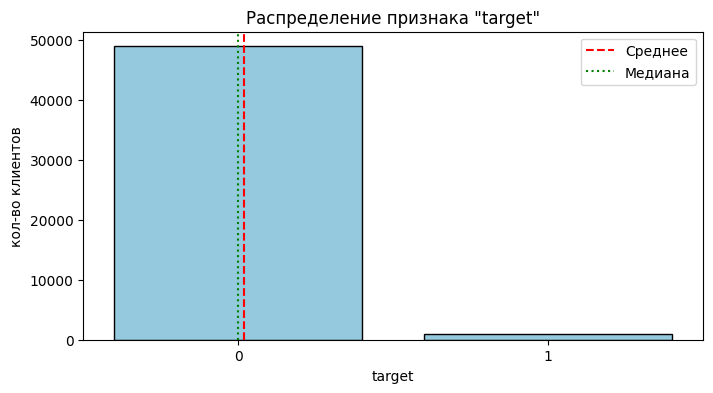

In [1373]:
custom_count_plot()

Статистика по столбцу 'price' датафрейм purchases:


,count,mean,std,min,25%,50%,75%,max,median
price,"202,208.00","1,193.30","1,342.25",1.00,352.00,987.00,"1,699.00","85,499.00",987.00


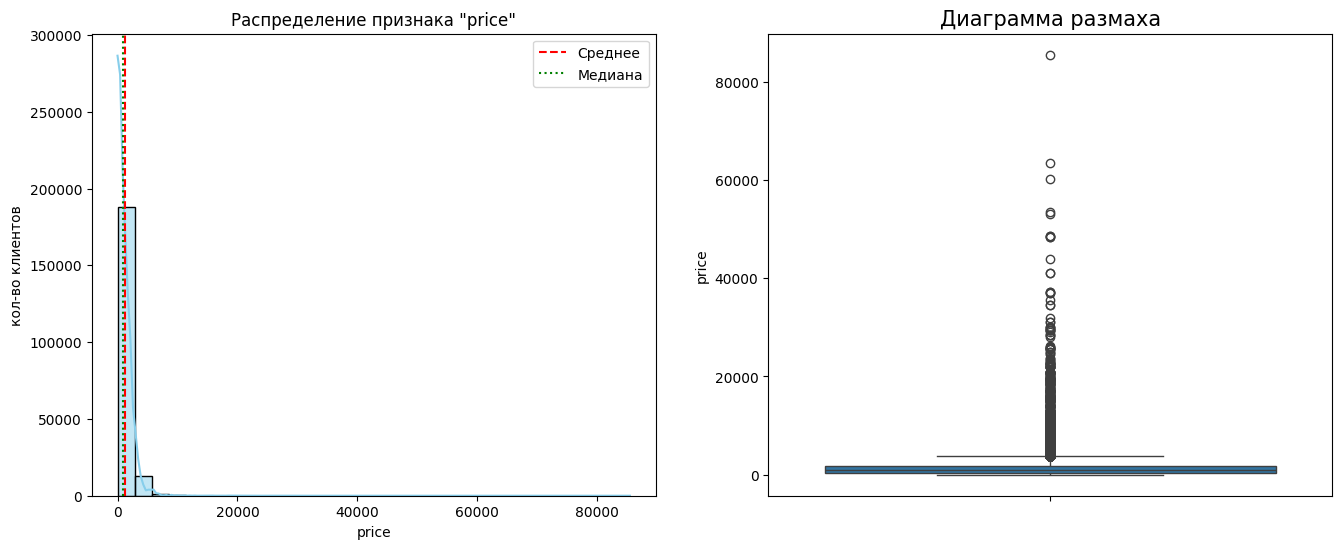

In [1374]:
custom_hist()

In [1375]:
def custom_count(data=messages,
                 figsize=(10, 5),
                 x='channel',
                 hue='event'):
    plt.figure(figsize=figsize)
    sns.countplot(data=data, x=x, palette='viridis', hue=hue)
    plt.title(f'Распределение по {x.lower()} в выбранном сегменте')
    # Автоповорот в зависимости от количества категорий
    if len(data[x].unique()) > 7:
        plt.xticks(rotation=45)
    else:
        plt.xticks(rotation=0)
    
    plt.tight_layout()
    plt.xlabel(x)
    plt.ylabel('Количество клиентов')
    plt.show()

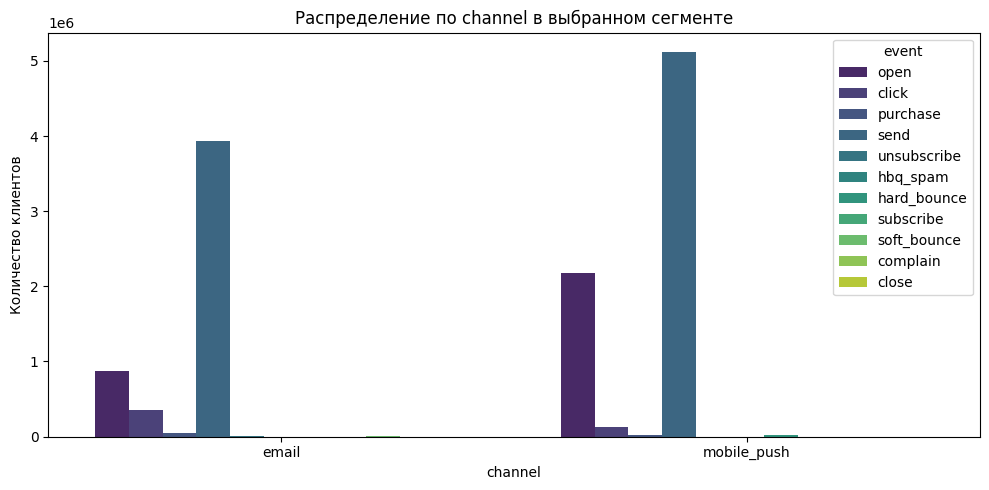

In [1376]:
custom_count()

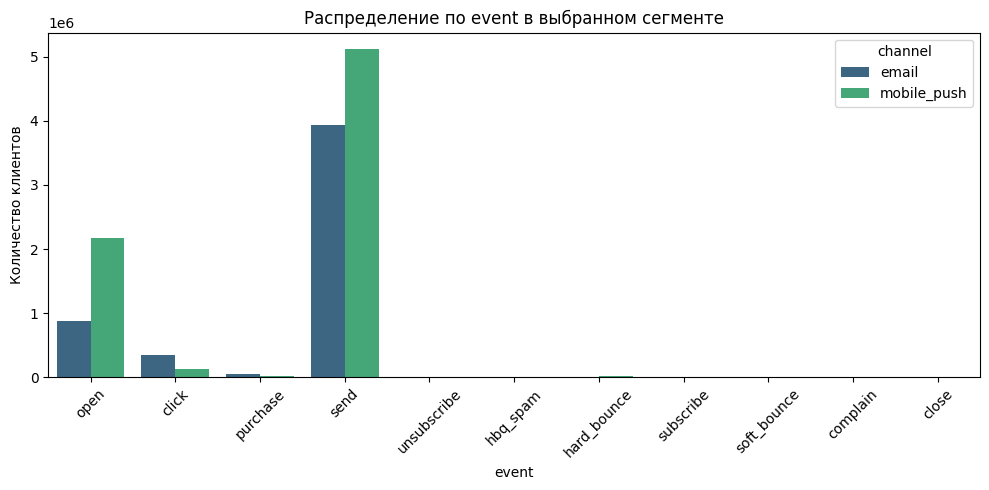

In [1377]:
custom_count(x='event', hue='channel')

In [1378]:
# Дополнительная функция для вывода сводной статистики
def print_summary_stats(data, x, hue):
    """Выводит сводную статистику по распределению"""
    print(f"Сводная статистика по {x} и {hue}:")
    print("=" * 50)
    
    # Создаем сводную таблицу
    pivot_table = pd.crosstab(data[x], data[hue], margins=True, margins_name="Всего")
    
    # Добавляем проценты по строкам
    pivot_percent = pd.crosstab(data[x], data[hue], normalize='index') * 100
    pivot_percent = pivot_percent.round(1)
    
    print("Абсолютные значения:")
    print(pivot_table)
    print("\nПроцентное распределение по строкам:")
    print(pivot_percent)
    
    # Общая статистика
    print(f"\nОбщее количество записей: {len(data):,}")
    print(f"Уникальных значений {x}: {data[x].nunique()}")
    print(f"Уникальных значений {hue}: {data[hue].nunique()}")

# Пример использования с выводом статистики
def enhanced_custom_count(data=messages,
                         figsize=(12, 6),
                         x='channel',
                         hue='event'):
    # Сначала выводим текстовую статистику
    print_summary_stats(data, x, hue)
    print("\n" + "="*50 + "\n")
    
    # Затем строим график
    custom_count(data, figsize, x, hue)
    custom_count(data, figsize, hue, x)

Анализ каналов и событий:
Сводная статистика по channel и event:
Абсолютные значения:
event         click  close  complain  hard_bounce  hbq_spam     open  \
channel                                                                
email        351949      0       527          359       823   873138   
mobile_push  131377      1         0        19404         0  2179343   
Всего        483326      1       527        19763       823  3052481   

event        purchase     send  soft_bounce  subscribe  unsubscribe     Всего  
channel                                                                        
email           44215  3937221         9566         85         2833   5220716  
mobile_push     18378  5120953         1016          0            0   7470472  
Всего           62593  9058174        10582         85         2833  12691188  

Процентное распределение по строкам:
event        click  close  complain  hard_bounce  hbq_spam  open  purchase  \
channel                              

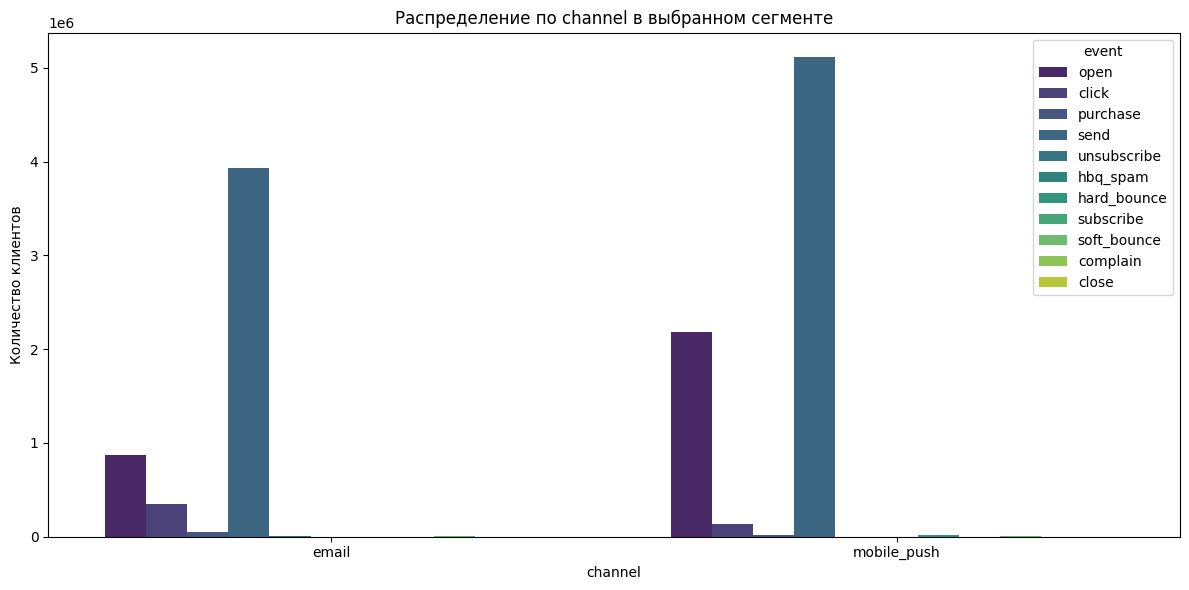

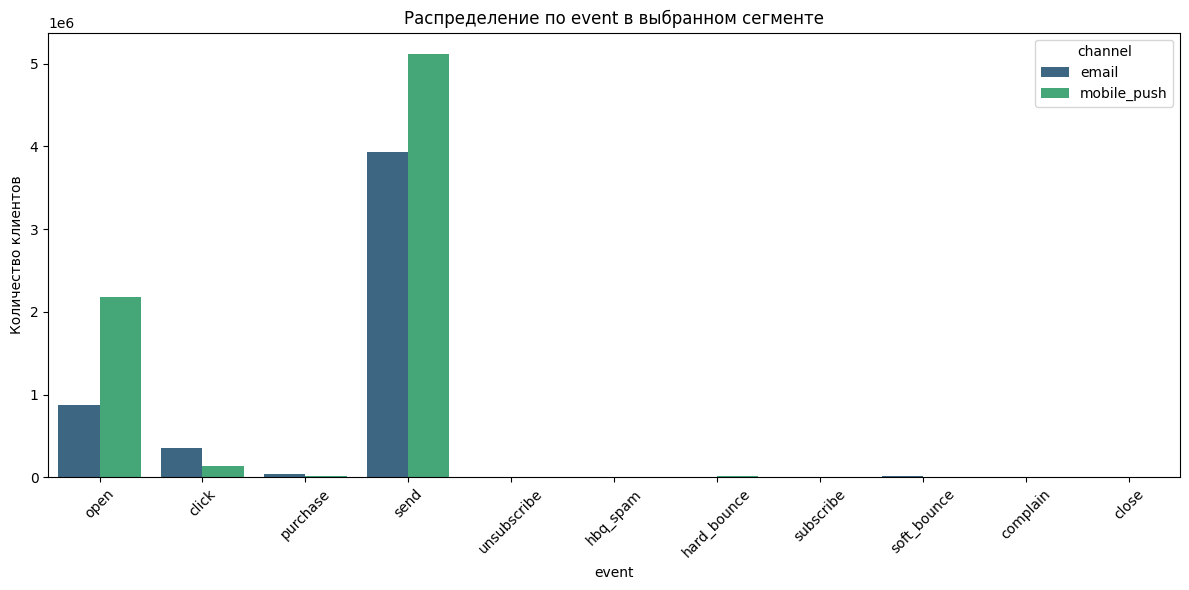

In [1379]:
# Анализ каналов и событий.
print("Анализ каналов и событий:")
enhanced_custom_count(messages, x='channel', hue='event')